<img src="https://www.mymetrotex.com/wp-content/uploads/2021/06/Untitled-design-2020-09-28T130055.657.png" />

In [1]:
# Standard imports
import numpy as np
import pandas as pd

# For statistical modeling
import scipy.stats as stats

# To acquire MYSQL Data
import acquire
from env import username, password, host
from wrangle import scale_data, train_validate_test, wrangle_zillow, remove_outliers, rfe
import evaluate

# For data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# For running modeling
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.linear_model import LogisticRegression, LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, RFE, f_regression, SequentialFeatureSelector

## Questions:
1. What are the most important features that determine a home's value?
2.
3.
4.

---

# Acquisition:
First acquire the data from my .csv file
zillow = acquire.get_zillow_2017() zillow.head()

In [6]:
zillow = pd.read_csv('zillow_2017_w_transactiondate.csv')
zillow.head()

,Unnamed: 0,propertylandusetypeid,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate,propertylandusedesc
0,0,261.0,14297519,1727539,NaN,NaN,NaN,3.5,4.0,NaN,...,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0,0.025595,2017-01-01,Single Family Residential
1,1,261.0,17052889,1387261,NaN,NaN,NaN,1.0,2.0,NaN,...,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,1,0.055619,2017-01-01,Single Family Residential
2,2,261.0,14186244,11677,NaN,NaN,NaN,2.0,3.0,NaN,...,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,2,0.005383,2017-01-01,Single Family Residential
3,3,261.0,12177905,2288172,NaN,NaN,NaN,3.0,4.0,NaN,...,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,3,-0.103410,2017-01-01,Single Family Residential
4,4,266.0,10887214,1970746,1.0,NaN,NaN,3.0,3.0,NaN,...,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13,4,0.006940,2017-01-01,Condominium


In [7]:
zillow

,Unnamed: 0,propertylandusetypeid,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate,propertylandusedesc
0,0,261.0,14297519,1727539,NaN,NaN,NaN,3.5,4.0,NaN,...,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0,0.025595,2017-01-01,Single Family Residential
1,1,261.0,17052889,1387261,NaN,NaN,NaN,1.0,2.0,NaN,...,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,1,0.055619,2017-01-01,Single Family Residential
2,2,261.0,14186244,11677,NaN,NaN,NaN,2.0,3.0,NaN,...,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,2,0.005383,2017-01-01,Single Family Residential
3,3,261.0,12177905,2288172,NaN,NaN,NaN,3.0,4.0,NaN,...,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,3,-0.103410,2017-01-01,Single Family Residential
4,4,266.0,10887214,1970746,1.0,NaN,NaN,3.0,3.0,NaN,...,2016.0,45726.0,1533.89,NaN,NaN,6.037124e+13,4,0.006940,2017-01-01,Condominium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77575,77575,261.0,11000655,673515,NaN,NaN,NaN,2.0,2.0,NaN,...,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13,77609,0.020615,2017-09-20,Single Family Residential
77576,77576,261.0,17239384,2968375,NaN,NaN,NaN,2.0,4.0,NaN,...,2016.0,16522.0,1107.48,NaN,NaN,6.111008e+13,77610,0.013209,2017-09-21,Single Family Residential
77577,77577,261.0,12773139,1843709,1.0,NaN,NaN,1.0,3.0,NaN,...,2016.0,16749.0,876.43,NaN,NaN,6.037434e+13,77611,0.037129,2017-09-21,Single Family Residential
77578,77578,261.0,12826780,1187175,NaN,NaN,NaN,2.0,3.0,NaN,...,2016.0,382000.0,6317.15,NaN,NaN,6.037503e+13,77612,0.007204,2017-09-25,Single Family Residential


52442 original observations of SFH. 64 different features

---

# Preparation: 

## Analysis will be focused on Single Family Homes
#### - Within the wrangle file, I will be using a function that only includes SFH and 6 features
#### - That same function imputes either the median or the mode of columns values for any nulls

In [3]:
zillow = wrangle_zillow(zillow)
zillow

Number of observations removed: 19014
Percentage of original Dataframe: 0.36


/Users/everettclark/Desktop/codeup-data-science/zillow_project/wrangle.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['month'] = df['transactiondate'].str[5:7]
/Users/everettclark/Desktop/codeup-data-science/zillow_project/wrangle.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['transactiondate'] = df['transactiondate'].str[:4]
/Users/everettclark/Desktop/codeup-data-science/zillow_project/wrangle.py:240: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

,bathrooms,bedrooms,bldg_quality,f_sqft,fips,lot_size,zip,tax_value
0,3.5,4.0,6.0,3100.0,6059.0,4506.0,96978.0,1023282.0
1,1.0,2.0,6.0,1465.0,6111.0,12647.0,97099.0,464000.0
2,2.0,3.0,6.0,1243.0,6059.0,8432.0,97078.0,564778.0
7,1.0,2.0,5.0,738.0,6037.0,4214.0,96325.0,218552.0
10,3.0,4.0,8.0,2540.0,6037.0,10384.0,96374.0,430108.0
...,...,...,...,...,...,...,...,...
77569,3.0,4.0,8.0,2068.0,6037.0,7333.0,96508.0,332251.0
77572,2.0,3.0,6.0,1570.0,6037.0,7499.0,96342.0,72026.0
77573,2.0,4.0,6.0,1633.0,6037.0,4630.0,96204.0,346534.0
77576,2.0,4.0,6.0,1612.0,6111.0,12105.0,97116.0,67205.0


In [4]:
zillow.describe().T

,count,mean,std,min,25%,50%,75%,max
bathrooms,33427.0,2.242693,0.639324,1.0,2.0,2.0,3.0,4.0
bedrooms,33427.0,3.315793,0.762626,2.0,3.0,3.0,4.0,5.0
bldg_quality,33427.0,6.407904,0.841492,5.0,6.0,6.0,6.0,8.0
f_sqft,33427.0,1777.707901,573.391461,152.0,1355.0,1664.0,2115.0,3599.0
fips,33427.0,6051.827176,22.326095,6037.0,6037.0,6037.0,6059.0,6111.0
lot_size,33427.0,6813.956771,2095.481558,1643.0,5573.0,6710.0,7903.5,12718.0
zip,33427.0,96636.145391,420.782638,95982.0,96247.0,96492.0,97023.0,97330.0
tax_value,33427.0,391395.211266,246421.728672,9242.0,190367.0,362378.0,545430.5,1151000.0


## Lastly, the data will be separated in to Train, Validate, and Test

In [5]:
zillow = zillow[['bedrooms','bathrooms', 'f_sqft','bldg_quality', 'zip','tax_value','lot_size']]
zillow

,bedrooms,bathrooms,f_sqft,bldg_quality,zip,tax_value,lot_size
0,4.0,3.5,3100.0,6.0,96978.0,1023282.0,4506.0
1,2.0,1.0,1465.0,6.0,97099.0,464000.0,12647.0
2,3.0,2.0,1243.0,6.0,97078.0,564778.0,8432.0
7,2.0,1.0,738.0,5.0,96325.0,218552.0,4214.0
10,4.0,3.0,2540.0,8.0,96374.0,430108.0,10384.0
...,...,...,...,...,...,...,...
77569,4.0,3.0,2068.0,8.0,96508.0,332251.0,7333.0
77572,3.0,2.0,1570.0,6.0,96342.0,72026.0,7499.0
77573,4.0,2.0,1633.0,6.0,96204.0,346534.0,4630.0
77576,4.0,2.0,1612.0,6.0,97116.0,67205.0,12105.0


In [9]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77580 entries, 0 to 77579
Data columns (total 64 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    77580 non-null  int64  
 1   propertylandusetypeid         77580 non-null  float64
 2   parcelid                      77580 non-null  int64  
 3   id                            77580 non-null  int64  
 4   airconditioningtypeid         25007 non-null  float64
 5   architecturalstyletypeid      207 non-null    float64
 6   basementsqft                  50 non-null     float64
 7   bathroomcnt                   77580 non-null  float64
 8   bedroomcnt                    77580 non-null  float64
 9   buildingclasstypeid           15 non-null     float64
 10  buildingqualitytypeid         49810 non-null  float64
 11  calculatedbathnbr             76964 non-null  float64
 12  decktypeid                    614 non-null    float64
 13  f

In [6]:
X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(zillow, 'tax_value')

In [7]:
X_train_scaled, X_validate_scaled, X_test_scaled = scale_data(X_train, X_validate, X_test)

In [8]:
y_train = pd.DataFrame(y_train)
y_validate = pd.DataFrame(y_validate)
y_train.head()

,tax_value
36552,125461.0
32274,676532.0
1459,682187.0
1352,77318.0
71163,803805.0


In [9]:
# create the model object
lm = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit
lm.fit(X_train, y_train.tax_value)

# predict train
# use
y_train['value_pred_lm'] = lm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_lm) ** (1/2)
# predict validate
y_validate['value_pred_lm'] = lm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_lm) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  222736.41736299978 
Validation/Out-of-Sample:  223165.99604961163


In [10]:
# create the model object
lars = LassoLars(alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series!
lars.fit(X_train, y_train.tax_value)

# predict train
y_train['value_pred_lars'] = lars.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_lars) ** 0.5

# predict validate
y_validate['value_pred_lars'] = lars.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_lars) ** 0.5

print("RMSE for Lasso + Lars\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for Lasso + Lars
Training/In-Sample:  222736.41736299975 
Validation/Out-of-Sample:  223165.99604961163


In [22]:
 # create the model object
glm = TweedieRegressor(power=0, alpha=0)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 

glm.fit(X_train, y_train.tax_value)

# predict train
y_train['value_pred_glm'] = glm.predict(X_train)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_glm) ** 0.5


# predict validate
y_validate['value_pred_glm'] = glm.predict(X_validate)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_glm) ** 0.5


print("RMSE for GLM using Tweedie, power=1 & alpha=0\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for GLM using Tweedie, power=1 & alpha=0
Training/In-Sample:  222912.35828981156 
Validation/Out-of-Sample:  223448.03195863907


In [17]:
# make the polynomial features to get a new set of features
pf = PolynomialFeatures(degree=3)

# fit and transform X_train_scaled
X_train_degree2 = pf.fit_transform(X_train)

# transform X_validate_scaled & X_test_scaled
X_validate_degree2 = pf.transform(X_validate)
X_test_degree2 = pf.transform(X_test)

## **LinearRegression**

# create the model object
lm2 = LinearRegression(normalize=True)

# fit the model to our training data. We must specify the column in y_train, 
# since we have converted it to a dataframe from a series! 
# 
# fit 
lm2.fit(X_train_degree2, y_train.tax_value)

# predict train
# 
# use the thing!
y_train['value_pred_lm2'] = lm2.predict(X_train_degree2)

# evaluate: rmse
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_lm2) ** (1/2)
# predict validate
y_validate['value_pred_lm2'] = lm2.predict(X_validate_degree2)

# evaluate: rmse
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_lm2) ** (1/2)

print("RMSE for OLS using LinearRegression\nTraining/In-Sample: ", rmse_train, 
      "\nValidation/Out-of-Sample: ", rmse_validate)

RMSE for OLS using LinearRegression
Training/In-Sample:  214999.88384172067 
Validation/Out-of-Sample:  215905.07459082242


In [13]:
# 1. Predict value_pred_mean
value_pred_mean = y_train.tax_value.mean()
y_train['value_pred_mean'] = value_pred_mean
y_validate['value_pred_mean'] = value_pred_mean

# 2. compute value_pred_median
value_pred_median = y_train.tax_value.median()
y_train['value_pred_median'] = value_pred_median
y_validate['value_pred_median'] = value_pred_median

# 3. RMSE of value_pred_mean
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_mean)**0.5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_mean)**0.5

print("RMSE using Mean\nTrain/In-Sample: ", round(rmse_train, 2), 
      "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

# 4. RMSE of value_pred_median
rmse_train = mean_squared_error(y_train.tax_value, y_train.value_pred_median)**0.5
rmse_validate = mean_squared_error(y_validate.tax_value, y_validate.value_pred_median)**0.5
print("RMSE using Median\nTrain/In-Sample: ", round(rmse_train, 2), 
       "\nValidate/Out-of-Sample: ", round(rmse_validate, 2))

RMSE using Mean
Train/In-Sample:  248535.15 
Validate/Out-of-Sample:  250965.86
RMSE using Median
Train/In-Sample:  249752.54 
Validate/Out-of-Sample:  252292.63


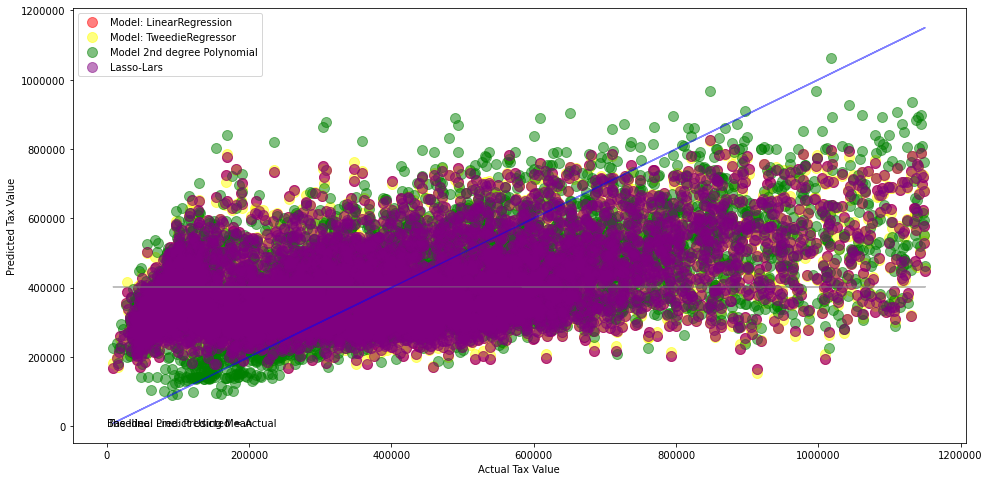

In [14]:
plt.figure(figsize=(16,8))
plt.plot(y_validate.tax_value, y_validate.value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
plt.annotate("Baseline: Predict Using Mean", (16, 9.5))
plt.plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
plt.annotate("The Ideal Line: Predicted = Actual", (.5, 3.5))#, rotation=15.5

plt.scatter(y_validate.tax_value, y_validate.value_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
plt.scatter(y_validate.tax_value, y_validate.value_pred_glm, 
             alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
plt.scatter(y_validate.tax_value, y_validate.value_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
plt.scatter(y_validate.tax_value, y_validate.value_pred_lars, 
            alpha=.5, color="purple", s=100, label="Lasso-Lars")
plt.ticklabel_format(style='plain')#
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


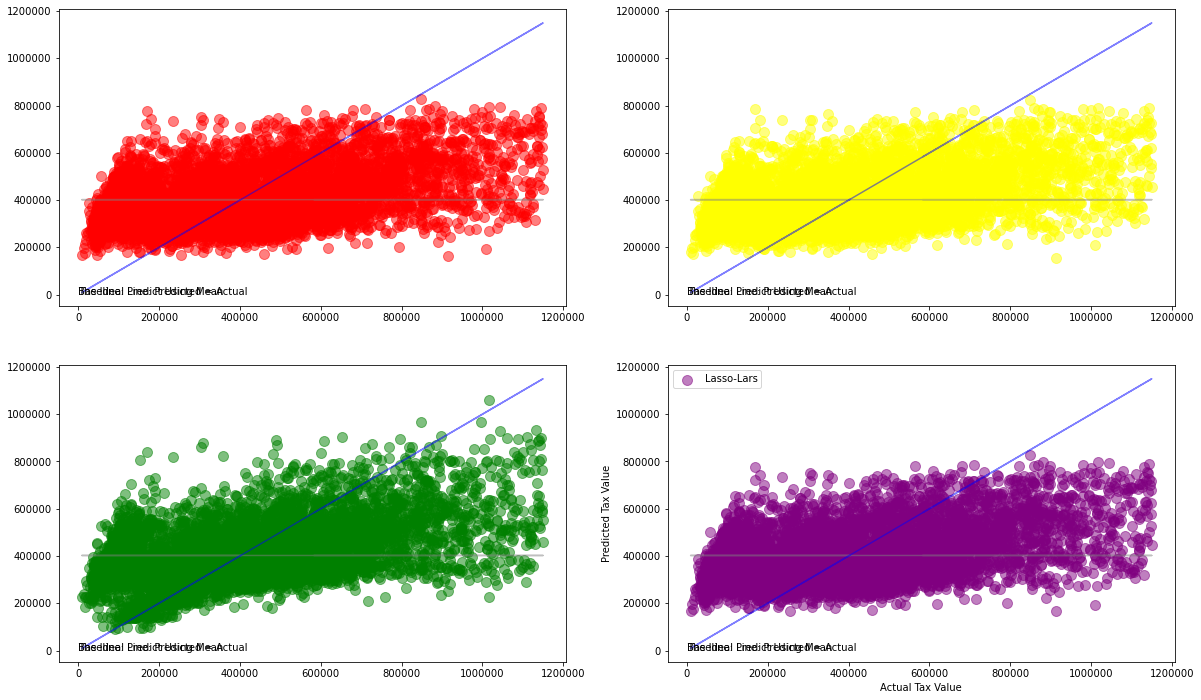

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))

# Plot 1
axs[0, 0].scatter(y_validate.tax_value, y_validate.value_pred_lm, 
            alpha=.5, color="red", s=100, label="Model: LinearRegression")
axs[0, 0].plot(y_validate.tax_value, y_validate.value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
axs[0, 0].annotate("Baseline: Predict Using Mean", (16, 9.5))
axs[0, 0].plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
axs[0, 0].annotate("The Ideal Line: Predicted = Actual", (.5, 3.5))#, rotation=15.5
axs[0, 0].ticklabel_format(style='plain')

# Plot 2
axs[0, 1].scatter(y_validate.tax_value, y_validate.value_pred_glm, 
             alpha=.5, color="yellow", s=100, label="Model: TweedieRegressor")
axs[0, 1].plot(y_validate.tax_value, y_validate.value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
axs[0, 1].annotate("Baseline: Predict Using Mean", (16, 9.5))
axs[0, 1].plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
axs[0, 1].annotate("The Ideal Line: Predicted = Actual", (.5, 3.5))
axs[0, 1].ticklabel_format(style='plain')
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")

# Plot 3
axs[1, 0].scatter(y_validate.tax_value, y_validate.value_pred_lm2, 
            alpha=.5, color="green", s=100, label="Model 2nd degree Polynomial")
axs[1, 0].plot(y_validate.tax_value, y_validate.value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
axs[1, 0].annotate("Baseline: Predict Using Mean", (16, 9.5))
axs[1, 0].plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
axs[1, 0].annotate("The Ideal Line: Predicted = Actual", (.5, 3.5))
axs[1, 0].ticklabel_format(style='plain')
plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")

# Plot 4
axs[1, 1].scatter(y_validate.tax_value, y_validate.value_pred_lars, 
            alpha=.5, color="purple", s=100, label="Lasso-Lars")
axs[1, 1].plot(y_validate.tax_value, y_validate.value_pred_mean, alpha=.5, color="gray", label='_nolegend_')
axs[1, 1].annotate("Baseline: Predict Using Mean", (16, 9.5))
axs[1, 1].plot(y_validate.tax_value, y_validate.tax_value, alpha=.5, color="blue", label='_nolegend_')
axs[1, 1].annotate("The Ideal Line: Predicted = Actual", (30, 30))
axs[1, 1].ticklabel_format(style='plain')

plt.legend()
plt.xlabel("Actual Tax Value")
plt.ylabel("Predicted Tax Value")
plt.show()

---

# Exploration and Pre-Processing:

---

# Modeling:

---

# Findings:

In [12]:
zillow.fips.value_counts()

6037.0    50697
6059.0    20631
6111.0     6252
Name: fips, dtype: int64

In [19]:
zillow = zillow[zillow.propertylandusedesc == 'Single Family Residential']

In [20]:
zillow1 = zillow[zillow.fips == 6037.0]
zillow2 = zillow[zillow.fips == 6059.0]
zillow3 = zillow[zillow.fips == 6111.0]

In [21]:
zillow1

,Unnamed: 0,propertylandusetypeid,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate,propertylandusedesc
3,3,261.0,12177905,2288172,NaN,NaN,NaN,3.0,4.0,NaN,...,2016.0,36225.0,1777.51,NaN,NaN,6.037300e+13,3,-0.103410,2017-01-01,Single Family Residential
6,6,261.0,12095076,781532,1.0,NaN,NaN,3.0,4.0,NaN,...,2016.0,496619.0,9516.26,NaN,NaN,6.037461e+13,6,-0.001011,2017-01-01,Single Family Residential
7,7,261.0,12069064,870991,NaN,NaN,NaN,1.0,2.0,NaN,...,2016.0,199662.0,2366.08,NaN,NaN,6.037302e+13,7,0.101723,2017-01-01,Single Family Residential
8,8,261.0,12790562,1246926,NaN,NaN,NaN,3.0,4.0,NaN,...,2016.0,43056.0,3104.19,NaN,NaN,6.037500e+13,8,-0.040966,2017-01-02,Single Family Residential
10,10,261.0,11104527,1639362,1.0,NaN,NaN,3.0,4.0,NaN,...,2016.0,158393.0,6103.36,NaN,NaN,6.037920e+13,10,0.005963,2017-01-02,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77573,77573,261.0,12412492,2274245,NaN,NaN,NaN,2.0,4.0,NaN,...,2016.0,221068.0,4175.08,NaN,NaN,6.037555e+13,77607,0.001082,2017-09-19,Single Family Residential
77575,77575,261.0,11000655,673515,NaN,NaN,NaN,2.0,2.0,NaN,...,2016.0,283704.0,4478.43,NaN,NaN,6.037101e+13,77609,0.020615,2017-09-20,Single Family Residential
77577,77577,261.0,12773139,1843709,1.0,NaN,NaN,1.0,3.0,NaN,...,2016.0,16749.0,876.43,NaN,NaN,6.037434e+13,77611,0.037129,2017-09-21,Single Family Residential
77578,77578,261.0,12826780,1187175,NaN,NaN,NaN,2.0,3.0,NaN,...,2016.0,382000.0,6317.15,NaN,NaN,6.037503e+13,77612,0.007204,2017-09-25,Single Family Residential


In [22]:
zillow2

,Unnamed: 0,propertylandusetypeid,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate,propertylandusedesc
0,0,261.0,14297519,1727539,NaN,NaN,NaN,3.5,4.0,NaN,...,2016.0,537569.0,11013.72,NaN,NaN,6.059063e+13,0,0.025595,2017-01-01,Single Family Residential
2,2,261.0,14186244,11677,NaN,NaN,NaN,2.0,3.0,NaN,...,2016.0,479489.0,6488.30,NaN,NaN,6.059022e+13,2,0.005383,2017-01-01,Single Family Residential
13,13,261.0,13944538,249412,13.0,NaN,NaN,2.5,3.0,NaN,...,2016.0,223051.0,4078.08,NaN,NaN,6.059089e+13,13,0.045602,2017-01-02,Single Family Residential
16,16,261.0,14375300,1548721,13.0,NaN,NaN,2.0,4.0,NaN,...,2016.0,359729.0,5496.44,NaN,NaN,6.059052e+13,16,-0.021896,2017-01-02,Single Family Residential
21,21,261.0,14387959,1623211,NaN,NaN,NaN,2.5,3.0,NaN,...,2016.0,423944.0,6172.28,NaN,NaN,6.059042e+13,21,-0.006653,2017-01-02,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77116,77116,261.0,14399681,86968,NaN,NaN,NaN,3.0,4.0,NaN,...,2016.0,54721.0,2170.14,NaN,NaN,6.059063e+13,77150,0.175712,2017-09-15,Single Family Residential
77130,77130,261.0,13976300,771386,NaN,NaN,NaN,2.0,3.0,NaN,...,2016.0,556973.0,7109.00,NaN,NaN,6.059099e+13,77164,-0.020225,2017-09-17,Single Family Residential
77154,77154,261.0,14284230,2534599,NaN,NaN,NaN,4.5,5.0,NaN,...,2016.0,524181.0,21280.68,NaN,NaN,6.059076e+13,77188,0.091490,2017-09-18,Single Family Residential
77193,77193,261.0,14177337,2680825,NaN,NaN,NaN,3.0,4.0,NaN,...,2016.0,193125.0,7243.84,NaN,NaN,6.059012e+13,77227,0.010171,2017-09-18,Single Family Residential


In [23]:
zillow3

,Unnamed: 0,propertylandusetypeid,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyflag,taxdelinquencyyear,censustractandblock,id.1,logerror,transactiondate,propertylandusedesc
1,1,261.0,17052889,1387261,NaN,NaN,NaN,1.0,2.0,NaN,...,2016.0,376000.0,5672.48,NaN,NaN,6.111001e+13,1,0.055619,2017-01-01,Single Family Residential
15,15,261.0,17110996,43675,NaN,NaN,NaN,2.5,3.0,NaN,...,2016.0,99028.0,2204.84,NaN,NaN,6.111005e+13,15,0.008669,2017-01-02,Single Family Residential
130,130,261.0,17134185,2490820,NaN,NaN,NaN,2.0,4.0,NaN,...,2016.0,273509.0,4557.52,NaN,NaN,6.111006e+13,130,0.057690,2017-01-03,Single Family Residential
134,134,261.0,17292247,269618,NaN,NaN,NaN,2.0,3.0,NaN,...,2016.0,24808.0,1450.06,NaN,NaN,6.111006e+13,134,-0.421908,2017-01-03,Single Family Residential
138,138,261.0,17141654,74982,NaN,NaN,NaN,3.0,4.0,NaN,...,2016.0,126138.0,4139.18,NaN,NaN,6.111005e+13,138,-0.021898,2017-01-03,Single Family Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76710,76710,261.0,17221434,1997485,NaN,NaN,NaN,3.0,4.0,NaN,...,2016.0,259400.0,7316.00,NaN,NaN,6.111008e+13,76744,0.035605,2017-09-14,Single Family Residential
76714,76714,261.0,17249040,2163386,NaN,NaN,NaN,3.0,4.0,NaN,...,2016.0,207727.0,5952.94,NaN,NaN,6.111008e+13,76748,-0.022050,2017-09-14,Single Family Residential
76717,76717,261.0,17159451,2669734,NaN,NaN,NaN,2.5,3.0,NaN,...,2016.0,22741.0,1225.24,NaN,NaN,6.111003e+13,76751,0.042637,2017-09-14,Single Family Residential
76724,76724,261.0,17149414,2311909,NaN,NaN,NaN,2.0,4.0,NaN,...,2016.0,104647.0,3630.48,NaN,NaN,6.111004e+13,76758,-0.014314,2017-09-14,Single Family Residential


In [26]:
zillow1.describe()

,Unnamed: 0,propertylandusetypeid,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,id.1,logerror
count,33911.000000,33911.0,3.391100e+04,3.391100e+04,11602.0,0.0,0.0,33911.000000,33911.000000,0.0,...,0.0,3.383900e+04,3.391100e+04,33911.0,3.391100e+04,33907.000000,1747.000000,3.384100e+04,33911.000000,33911.000000
mean,38839.242252,261.0,1.193477e+07,1.500734e+06,1.0,NaN,NaN,2.192091,3.198107,NaN,...,NaN,1.857668e+05,5.002361e+05,2016.0,3.148638e+05,6313.266806,14.116772,6.038708e+13,38856.509097,0.015403
std,22569.338132,0.0,3.246095e+06,8.591448e+05,0.0,NaN,NaN,1.058907,0.954295,NaN,...,NaN,2.687462e+05,8.266645e+05,0.0,6.328671e+05,9750.926072,2.527305,2.297553e+12,22577.625774,0.171268
min,3.000000,261.0,1.071186e+07,1.433000e+03,1.0,NaN,NaN,0.000000,0.000000,NaN,...,NaN,1.290000e+02,1.000000e+03,2016.0,1.610000e+02,120.840000,4.000000,6.037101e+13,3.000000,-4.655420
25%,19142.500000,261.0,1.120690e+07,7.663400e+05,1.0,NaN,NaN,2.000000,3.000000,NaN,...,NaN,7.308600e+04,1.648755e+05,2016.0,5.650500e+04,2410.715000,14.000000,6.037235e+13,19152.500000,-0.029370
50%,38776.000000,261.0,1.188349e+07,1.501092e+06,1.0,NaN,NaN,2.000000,3.000000,NaN,...,NaN,1.231060e+05,3.235830e+05,2016.0,1.838850e+05,4275.770000,15.000000,6.037432e+13,38791.000000,0.006210
75%,58210.000000,261.0,1.249952e+07,2.245752e+06,1.0,NaN,NaN,3.000000,4.000000,NaN,...,NaN,2.050000e+05,5.527650e+05,2016.0,3.630000e+05,6941.895000,15.000000,6.037578e+13,58234.000000,0.042333
max,77579.000000,261.0,1.676878e+08,2.982167e+06,1.0,NaN,NaN,18.000000,14.000000,NaN,...,NaN,9.164901e+06,4.906124e+07,2016.0,4.895220e+07,586639.300000,99.000000,4.830301e+14,77613.000000,5.262999


In [27]:
zillow2.describe()

,Unnamed: 0,propertylandusetypeid,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,id.1,logerror
count,14136.000000,14136.0,1.413600e+04,1.413600e+04,2036.000000,70.00000,0.0,14136.000000,14136.000000,0.0,...,81.0,1.412700e+04,1.413500e+04,14136.0,1.413500e+04,14136.000000,288.00000,1.410200e+04,14136.000000,14136.000000
mean,38732.926853,261.0,1.419979e+07,1.499260e+06,10.632613,7.10000,NaN,2.503572,3.464488,NaN,...,1.0,2.092484e+05,6.046852e+05,2016.0,3.955552e+05,6958.036759,14.18750,6.059058e+13,38750.067982,0.026366
std,21934.038547,0.0,5.853630e+05,8.576672e+05,4.489748,2.66567,NaN,0.921161,0.920089,NaN,...,0.0,2.361953e+05,6.198558e+05,0.0,4.586064e+05,6922.356447,1.45055,3.176667e+08,21942.008007,0.197113
min,0.000000,261.0,1.383453e+07,1.035100e+04,1.000000,2.00000,NaN,0.000000,0.000000,NaN,...,1.0,8.440000e+02,1.352400e+04,2016.0,4.126000e+03,85.940000,7.00000,6.059001e+13,0.000000,-2.406257
25%,20074.250000,261.0,1.402361e+07,7.574640e+05,13.000000,7.00000,NaN,2.000000,3.000000,NaN,...,1.0,7.742800e+04,2.744150e+05,2016.0,1.433985e+05,3216.070000,14.00000,6.059032e+13,20086.250000,-0.017355
50%,38910.500000,261.0,1.420051e+07,1.503264e+06,13.000000,7.00000,NaN,2.500000,3.000000,NaN,...,1.0,1.319120e+05,4.729470e+05,2016.0,3.168630e+05,5404.580000,15.00000,6.059063e+13,38925.500000,0.008371
75%,57710.500000,261.0,1.437690e+07,2.233830e+06,13.000000,7.00000,NaN,3.000000,4.000000,NaN,...,1.0,2.534320e+05,7.280600e+05,2016.0,4.936925e+05,8227.440000,15.00000,6.059087e+13,57734.500000,0.038713
max,77222.000000,261.0,7.964049e+07,2.982270e+06,13.000000,21.00000,NaN,8.500000,9.000000,NaN,...,1.0,3.447889e+06,1.131768e+07,2016.0,9.138678e+06,115923.260000,15.00000,6.059111e+13,77256.000000,2.933328


In [25]:
zillow3.describe()

,Unnamed: 0,propertylandusetypeid,parcelid,id,airconditioningtypeid,architecturalstyletypeid,basementsqft,bathroomcnt,bedroomcnt,buildingclasstypeid,...,fireplaceflag,structuretaxvaluedollarcnt,taxvaluedollarcnt,assessmentyear,landtaxvaluedollarcnt,taxamount,taxdelinquencyyear,censustractandblock,id.1,logerror
count,4395.000000,4395.0,4.395000e+03,4.395000e+03,0.0,0.0,47.000000,4395.000000,4395.000000,0.0,...,0.0,4.392000e+03,4.395000e+03,4395.0,4.395000e+03,4395.000000,44.000000,4.376000e+03,4395.000000,4395.000000
mean,39230.744482,261.0,1.734965e+07,1.464352e+06,NaN,NaN,678.978723,2.470648,3.565188,NaN,...,NaN,2.385658e+05,5.156710e+05,2016.0,2.772681e+05,5912.029088,12.977273,6.111005e+13,39248.058703,0.014641
std,21853.806200,0.0,4.915238e+06,8.669015e+05,NaN,NaN,711.825226,0.921376,0.872645,NaN,...,NaN,1.791344e+05,4.607093e+05,0.0,3.144939e+05,5072.567406,1.562476,2.517367e+07,21861.734957,0.156142
min,1.000000,261.0,1.705102e+07,3.490000e+02,NaN,NaN,38.000000,0.000000,0.000000,NaN,...,NaN,2.027000e+03,7.771000e+03,2016.0,4.103000e+03,49.180000,9.000000,6.111000e+13,1.000000,-2.311473
25%,20648.500000,261.0,1.712326e+07,7.018090e+05,NaN,NaN,263.500000,2.000000,3.000000,NaN,...,NaN,1.441355e+05,2.856140e+05,2016.0,1.190135e+05,3274.180000,12.000000,6.111003e+13,20660.500000,-0.019255
50%,40023.000000,261.0,1.719452e+07,1.462851e+06,NaN,NaN,512.000000,2.000000,4.000000,NaN,...,NaN,2.042515e+05,4.426880e+05,2016.0,2.180780e+05,5049.260000,14.000000,6.111006e+13,40040.000000,0.006015
75%,58129.500000,261.0,1.724670e+07,2.221072e+06,NaN,NaN,809.500000,3.000000,4.000000,NaN,...,NaN,2.873725e+05,6.326925e+05,2016.0,3.568995e+05,7233.590000,14.000000,6.111008e+13,58153.500000,0.035566
max,77576.000000,261.0,1.629608e+08,2.981669e+06,NaN,NaN,3560.000000,8.500000,8.000000,NaN,...,NaN,3.935031e+06,1.319825e+07,2016.0,1.055860e+07,143336.720000,14.000000,6.111009e+13,77610.000000,2.311174


In [31]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52442 entries, 0 to 77579
Data columns (total 64 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    52442 non-null  int64  
 1   propertylandusetypeid         52442 non-null  float64
 2   parcelid                      52442 non-null  int64  
 3   id                            52442 non-null  int64  
 4   airconditioningtypeid         13638 non-null  float64
 5   architecturalstyletypeid      70 non-null     float64
 6   basementsqft                  47 non-null     float64
 7   bathroomcnt                   52442 non-null  float64
 8   bedroomcnt                    52442 non-null  float64
 9   buildingclasstypeid           0 non-null      float64
 10  buildingqualitytypeid         33741 non-null  float64
 11  calculatedbathnbr             52305 non-null  float64
 12  decktypeid                    389 non-null    float64
 13  f

In [32]:
zillow.columns

Index(['Unnamed: 0', 'propertylandusetypeid', 'parcelid', 'id',
       'airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft',
       'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'propertycountylandusecode', 'propertyzoningdesc',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'storytypeid',
       'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt',
       'yardbu

In [33]:
zillow = zillow[['propertylandusetypeid', 'parcelid', 'id',
       'airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft',
       'bathroomcnt', 'bedroomcnt', 'buildingclasstypeid',
       'buildingqualitytypeid', 'calculatedbathnbr', 'decktypeid',
       'finishedfloor1squarefeet', 'calculatedfinishedsquarefeet',
       'finishedsquarefeet12', 'finishedsquarefeet13', 'finishedsquarefeet15',
       'finishedsquarefeet50', 'finishedsquarefeet6', 'fips', 'fireplacecnt',
       'fullbathcnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa',
       'heatingorsystemtypeid', 'latitude', 'longitude', 'lotsizesquarefeet',
       'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7',
       'rawcensustractandblock', 'regionidcity', 'regionidcounty',
       'regionidneighborhood', 'regionidzip', 'roomcnt', 'storytypeid',
       'threequarterbathnbr', 'typeconstructiontypeid', 'unitcnt',
       'yardbuildingsqft17', 'yardbuildingsqft26', 'yearbuilt',
       'numberofstories', 'fireplaceflag', 'structuretaxvaluedollarcnt',
       'taxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt',
       'taxamount', 'taxdelinquencyyear',
       'censustractandblock', 'logerror']]

In [34]:
rfe(zillow, zillow.taxvaluedollarcnt, 8)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').